# Complexity and flexibility



## Polynomial regression

In [3]:
from dataclasses import dataclass

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# nice plots
sns.set_style("whitegrid")
plt.rc('legend', fontsize=14)
plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# need to run cell twice for this to take effect (don't know why)
plt.rcParams['figure.figsize'] = (10, 10)

# set random seed for reproducibility
np.random.seed(123)

In [4]:
@dataclass
class PolyModel:
    """Polynomial regression model parameters"""

    degree: int
    X_poly: np.ndarray=None
    lm: LinearRegression=None
    pipeline: Pipeline=None
    Y_hat: np.ndarray=None
    rmse: float=None
    r2: float=None


def fit_polynomial_models(X, Y, degree=20):
    """Function for fitting polynomial models up to degree=degree at once"""

    models = []
    for n in range(0, degree):
        model = PolyModel(degree=n)
        model.X_poly = PolynomialFeatures(degree=n).fit_transform(X.reshape(-1, 1))
        model.lm = LinearRegression().fit(model.X_poly, Y)
        model.Y_hat = model.lm.predict(model.X_poly)
        model.rmse = np.sqrt(mean_squared_error(Y, model.Y_hat))
        model.r2 = r2_score(Y, model.Y_hat)
        models.append(model)
    return(models)

In [5]:
# generate data with noise
X1 = np.random.normal(loc=10, scale=5, size=100)
e1 = np.random.normal(loc=0, scale=2500, size=100)
Y1 = (2530 + 20*X1 - 10*(X1**2) + 5*(X1**3) + e1)

# create models
models = fit_polynomial_models(X1, Y1)

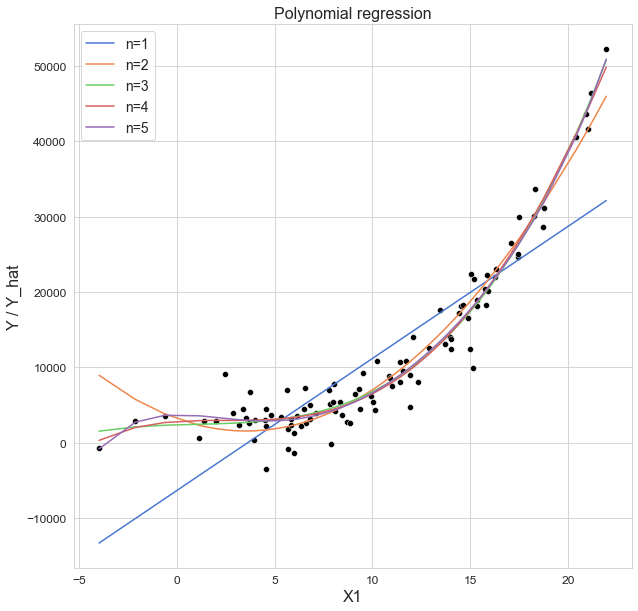

In [6]:
g = sns.scatterplot(x=X1, y=Y1, color='black')
g.set_title('Polynomial regression')
g.set_xlabel('X1')
g.set_ylabel('Y / Y_hat')

for n, color in enumerate(sns.color_palette('muted', 5)):
    sns.lineplot(x=X1, y=models[n+1].Y_hat, ax=g.axes, label=f"n={n+1}", color=color)

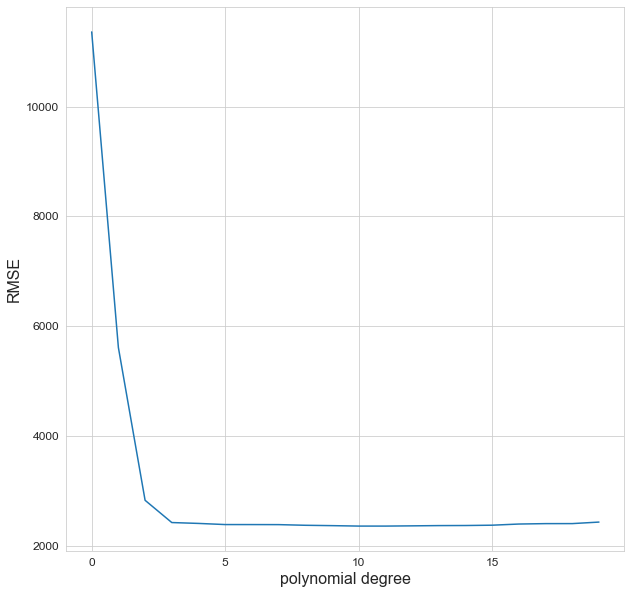

In [7]:
# plot errors for all models
g = sns.lineplot(x=[model.degree for model in models], y=[model.rmse for model in models]);
g.set_xticks(np.arange(0,20,5))
g.set_xlabel('polynomial degree')
g.set_ylabel('RMSE');

## Adding random input

In [8]:
# Create 7 input features X1, ... X7
X = np.hstack([np.random.normal(loc=10, scale=5, size=100).reshape(-1, 1) for n in range(0, 7)])

# But we only have a model with X[:,0]
e = np.random.normal(loc=0, scale=250, size=100)
Y = (2530 + 20*X[:,0] - 10*(X[:,0]**2) + 5*(X[:,0]**3) + e).reshape(-1, 1)

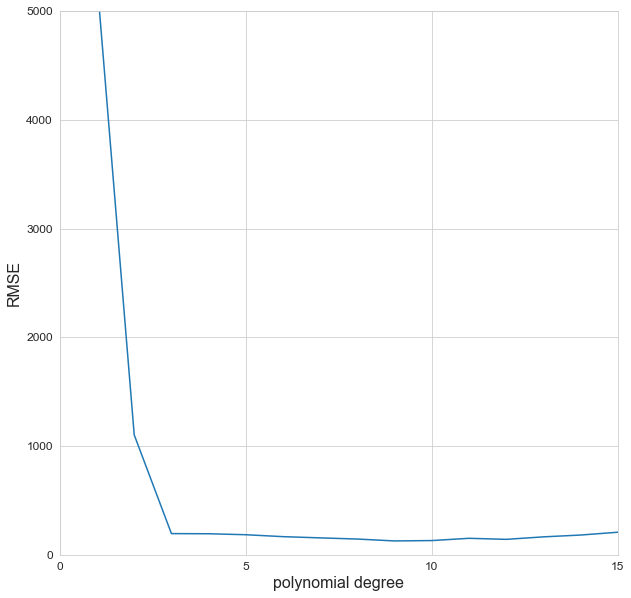

In [9]:
def make_polynomial(X, degree):
    """Turn np.ndarray X into polynomial with no interaction."""
    if degree > 0:
        return np.hstack([X**(i+1) for i in range(0,degree)])
    else:
        pass


silly_models = []
for n in range(1, 21):
    model = PolyModel(degree=n)
    model.X_poly = make_polynomial(X, degree=n) # polynomials with no interactions
    model.lm = LinearRegression().fit(model.X_poly, Y)
    model.Y_hat = model.lm.predict(model.X_poly)
    model.rmse = np.sqrt(mean_squared_error(Y, model.Y_hat))
    model.r2 = r2_score(Y, model.Y_hat)
    silly_models.append(model)

# plot errors for all models
g = sns.lineplot(x=[model.degree for model in silly_models], y=[model.rmse for model in silly_models]);
g.set_xlabel('polynomial degree')
g.set_ylabel('RMSE');
g.set_xticks(np.arange(0,20,5));
g.axis([0,15,0,5000]);

# Train-test split

## Using `np.polyfit`

In [10]:
# Same data generation as before, but now with train-test split
np.random.seed(456)
X4 = np.random.normal(-10, 6, 250)
e4 = np.random.normal(0, 100, 250)
Y4 = 25 + 2*X4 - 4*(X4**2) + e4
X4_train = X4[0:200]
X4_test = X4[200:]
e4_train = e4[0:200]
e4_test = e4[200:]
Y4_train = 25 + 2*X4_train - 4*(X4_train**2) + e4_train
Y4_test = 25 + 2*X4_test - 4*(X4_test**2) + e4_test

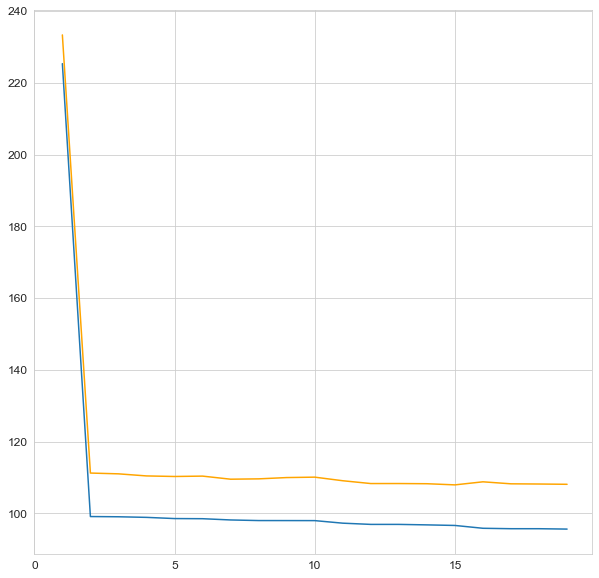

In [11]:
degree, rmse_train, rmse_test = [], [], []
for i in range(1,20):
    c = np.polyfit(X4, Y4, i)
    y_hat = np.polyval(c, X4)
    y_test_hat = np.polyval(c, X4_test)
    degree.append(i)
    rmse_train.append(np.sqrt(np.mean((Y4 - y_hat)**2)))
    rmse_test.append(np.sqrt(np.mean((Y4_test - y_test_hat)**2)))

g = sns.lineplot(x=degree, y=rmse_train)
sns.lineplot(x=degree, y=rmse_test, color='orange')
g.set_xticks(np.arange(0,20,5));

## Usign `sklearn` without standard scaling



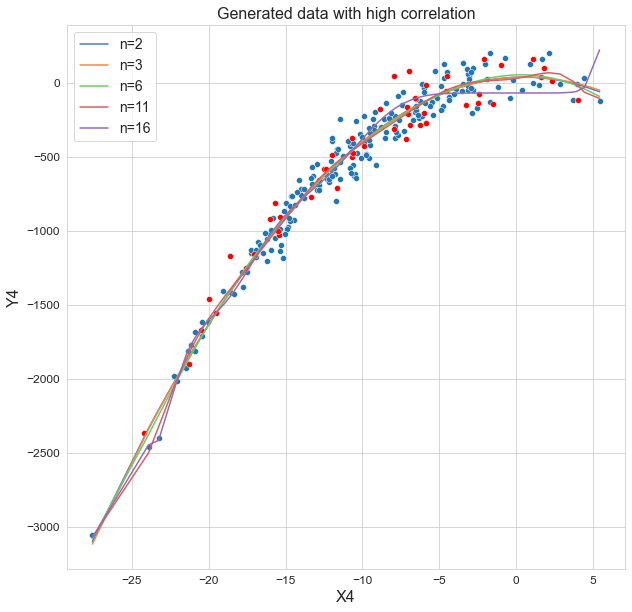

In [12]:
# using sklearn like before
raw_models = fit_polynomial_models(X4_train, Y4_train)

g = sns.scatterplot(x=X4_train, y=Y4_train)
g.set_title('Generated data with high correlation');
g.set_xlabel('X4')
g.set_ylabel('Y4')
sns.scatterplot(x=X4_test, y=Y4_test, color='red')
for n, color in zip([1,2,5,10,15], sns.color_palette('muted')):
    sns.lineplot(x=X4_train, y=raw_models[n+1].Y_hat, ax=g.axes, label=f"n={n+1}", color=color)

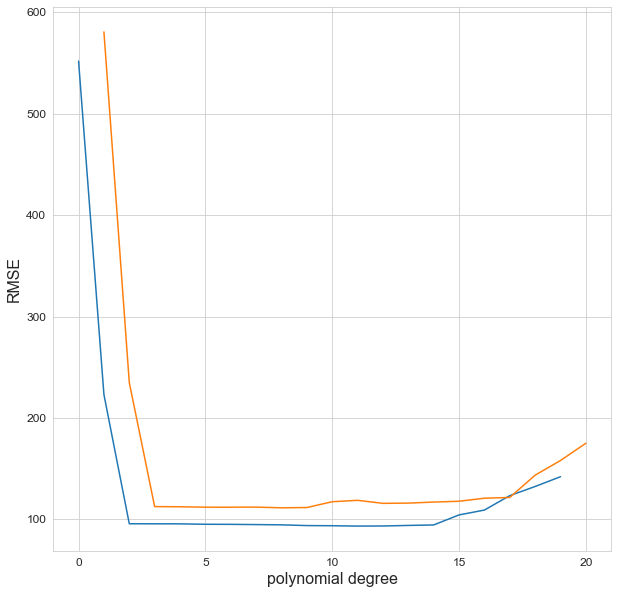

In [13]:
# calculate errors for validation data
raw_validation = []
for model in raw_models:
    X4_poly = PolynomialFeatures(model.degree).fit_transform(X4_test.reshape(-1, 1))
    Y_hat = model.lm.predict(X4_poly)
    raw_validation.append(np.sqrt(mean_squared_error(Y4_test, Y_hat)))

g = sns.lineplot(x=[model.degree for model in raw_models], y=[model.rmse for model in raw_models]);
sns.lineplot(x=range(1,21), y=raw_validation)
g.set_xticks(np.arange(0,25,5))
g.set_xlabel('polynomial degree')
g.set_ylabel('RMSE');

## Usign `sklearn` with standard scaling

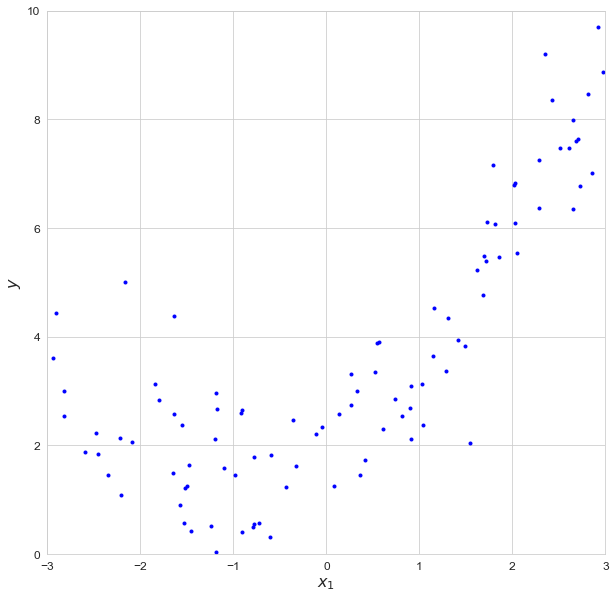

In [14]:
# generate data
m = 100
X5 = 6 * np.random.rand(m, 1) - 3
y5 = 0.5 * X5**2 + X5 + 2 + np.random.randn(m, 1)

plt.plot(X5, y5, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.axis([-3, 3, 0, 10]);

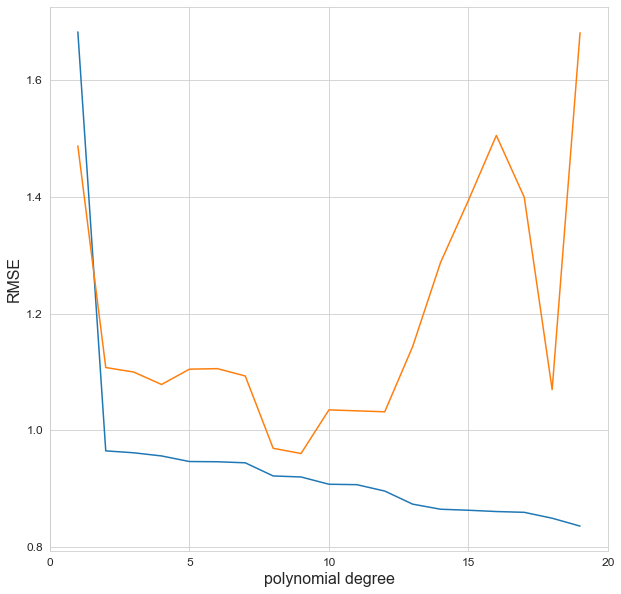

In [15]:
# train-test-slit in sklearn
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=42)

# for plotting
# X_new=np.linspace(-3, 3, 100).reshape(100, 1)

scaled_models = []
for degree in range(1,20):
    model = PolyModel(degree)
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    model.pipeline = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    model.pipeline.fit(X5_train, y5_train)
    model.Y_hat = model.pipeline.predict(X5_train)
    model.rmse = np.sqrt(mean_squared_error(y5_train, model.Y_hat))
    scaled_models.append(model)
    # plt.plot(X_new, model.Y_hat, style, label=str(degree), linewidth=width)

# calculate errors for validation data
scaled_validation = []
for model in scaled_models:
    y5_test_hat = model.pipeline.predict(X5_test)
    scaled_validation.append(np.sqrt(mean_squared_error(y5_test, y5_test_hat)))

g = sns.lineplot(x=[model.degree for model in scaled_models], y=[model.rmse for model in scaled_models]);
sns.lineplot(x=range(1,20), y=scaled_validation)
g.set_xticks(np.arange(0,25,5))
g.set_xlabel('polynomial degree')
g.set_ylabel('RMSE');